# Simulating Gene Distributions with Markov Chain Monte Carlo (MCMC)

The next step is to simulate the distribution of normalized gene counts for each gene. For simplicity, all references to protien coding gene data moving forward will pertain to normalized protien coding gene data unless otherwise specified.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro, kstest, anderson, norm, probplot
import scipy.stats as stats

import tools as tl

# load data
data = pd.read_csv("mt-datasets/Donor1_CD4_Genes.csv")
# normalization
data_norm = tl.TPM(data)


## 1. Choose a distribution type for the data

### Normal distribution
We'll begin with a normal distribution. To assess how well the data fits this distribution, we can start by plotting a Q-Q plot.

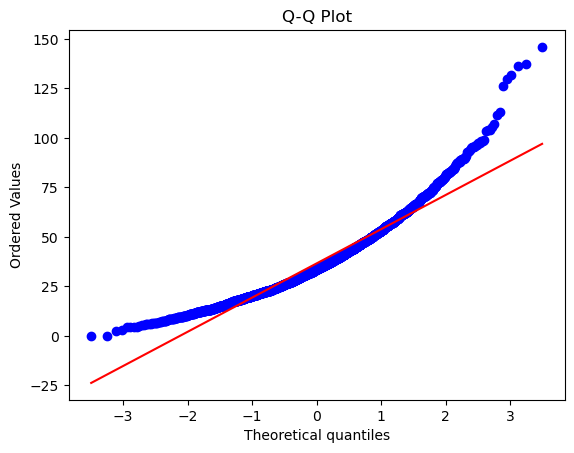

In [3]:
probplot(data_norm['MT-CO1'], dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

From the Q-Q plot, we observe that the data for MT-CO1 doesn't appear to follow a normal distribution. To further investigate the distribution across all different protien coding gene types, we then apply the Shapiro-Wilk Test.

In [4]:
test = False
for i in data_norm.columns:
    stat, p_value = shapiro(data_norm[i])

    if p_value > 0.05:
        # Fail to reject the null hypothesis - Data follows a normal distribution
        test = True
    else:
        # Reject the null hypothesis - Data does not follow a normal distribution
        continue

if not test:
    print('No data follows a normal distribution')
else:
    print('Exist data that follows a normal distribution')

No data follows a normal distribution


Based on these findings, we can conclude that the normal distribution is not a suitable model for simulating our data.

### Poisson distribution
We then test the fitness of poisson distribution by plotting the scatter plot of the variance and mean of each protien coding gene data.

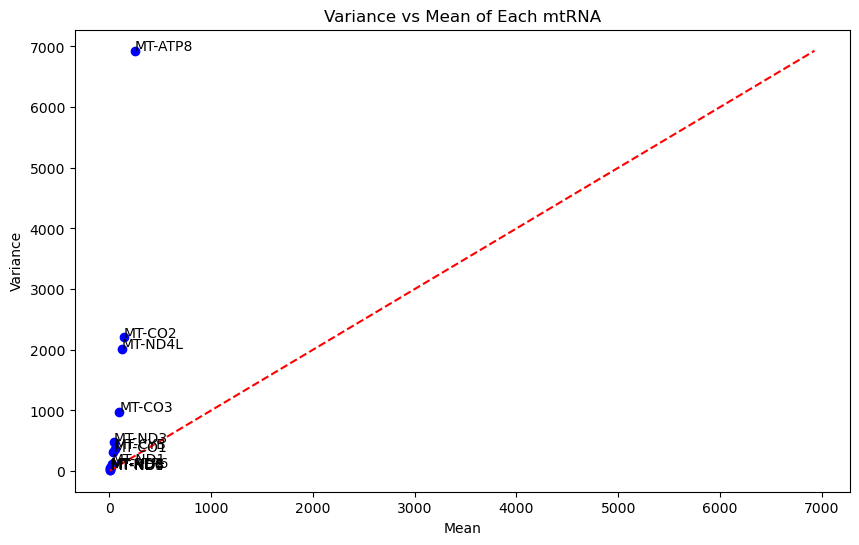

In [5]:
mean_values = data_norm.mean()
var_values = data_norm.var()

plt.figure(figsize=(10, 6))
plt.scatter(mean_values, var_values, color='blue')

# Annotate each point with the gene name
for i, gene in enumerate(data_norm.columns):
    plt.annotate(gene, (mean_values[gene], var_values[gene]))
min_val = min(min(mean_values), min(var_values))
max_val = max(max(mean_values), max(var_values))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

# Add titles and labels
plt.title('Variance vs Mean of Each mtRNA')
plt.xlabel('Mean')
plt.ylabel('Variance')

# Show plot
plt.show()

Since we know that in a Poisson distribution, the variance and mean should be equal, we can compare them to check the fit. From the plot, we observe that the scatter points of variance and mean do not align with the red line representing $x = y$. This indicates that the Poisson distribution is also not a suitable model for our data.

### Negative Binomial distribution
After finding that neither the normal nor the Poisson distribution fits our data, we turn to the negative binomial distribution as an alternative model.

## 2. Use MCMC to Construct a Negative Binomial Distribution

In this step, we will employ MCMC methods to estimate the parameters and construct a negative binomial distribution for our data. MCMC provides a flexible approach to sampling from complex distributions, where direct analytical solutions may be difficult to obtain.

### Metropolis algorithm(symmetric proposal distribution)

We will implement Bayesian inference using the Metropolis algorithm, a type of MCMC method that employs a symmetric proposal distribution. Here we assume our target quantity $y$ follows a distribution with probability function $P(x)$. The steps of this algorithm are outlined below.

#### 1. Initialize
We begin by choosing an initial value for the hyperparameters, denoted as $\bm{x}^{(0)}$. This initial value is usually selected randomly or based on some prior knowledge. Additionally, we define the proposal distributions $P_{x_i}$ for each parameter $x_i$. For simplicity, we assume that these proposal distributions are symmetric.

#### 2. Propose
- In each iteration $j$, we begin with the current hyperparameter values $\bm{x}^{(j)}$ and propose new values $\bm{x}^P$ by sampling from their respective proposal distributions. The parameters of these distributions are set based on the current values of the hyperparameters. 
- With these newly proposed values, referred to as the 'candidate', we then calculate the acceptance ratio: $$\alpha=\frac{P(\bm{x}^P)}{P(\bm{x}^{(j)})}.$$This ratio compares the likelihood of the candidate parameters against the current parameters.

#### 3. Accept or Not
Finally, we decide wether to accept or reject the the proposed values. We generate a random value $\mu$ from a uniform distribution $\text{Unif}(0,1)$ and compare this value with the acceptance ratio $\alpha$ we calculated previously. 
- $\mu\le\alpha$ we accept the candidate, and assign the value of $\bm{x}^P$ to $\bm{x}^{(j+1)}$.
- $\mu>\alpha$ we reject the candidate, and retain the current value by assigning $\bm{x}^{(j)}$ to $\bm{x}^{(j+1)}$.

#### 4. Continue
We then return to step two and continue generating new values for $\bm{x}$, repeating the process iteratively to build up a chain of parameter samples.


### Model
We first need to decide on the model for performing MCMC. The goal is to estimate the parameters for the normalized gene counts. For each gene $i$, here we assume that the corresponding random variable $Y_i$ follows a Poisson distribution with mean $\mu$ and size $r$. 
$$
Y_i|\mu_i,r_i \sim NB(\mu_i,r_i)
$$
The probability parameter $p$ of the negative binomial distribution can be expressed in terms of $\mu$ and $r$, where:
$p = \frac{r}{\mu+r}.$

In the Metropolis algorithm, we use symmetric proposal distributions. Therefore, we choose the following:
- For $\mu$ we use a normal distribution as the proposal distribution.
$$
\mu^{(j+1)}\sim N(\mu^{(j)}, \sigma_\mu^2)
$$
- For $r$ we use a truncated normal (truncnorm) distribution because $r$ must be positive according to the definition of the negative binomial distribution.
$$
r^{(j+1)}\sim\text{TruncNorm}(r^{(j)},\sigma_r,a =0,b=\infty)
$$
Note that for the truncated normal distribution, the parameters $a$ and $b$ define the range of the distribution, ensuring that proposed values for $r$ are always positive. Additionally, $\sigma_\mu$ and $\sigma_r$ are pre-set parameters that determine the spread of the proposal distributions for $\mu$ and $r$, respectively.

### Acceptance ratio
Given that the acceptance ratio $\alpha$ is defined as: $\frac{P(\bm{x}^P)}{P(\bm{x}^{(j)})}$ where $P$  is the density function of the negative binomial distribution. We can express $\alpha$ as follows:
\begin{aligned}
\alpha = 
\end{aligned}


In [6]:
from scipy.special import gammaln
from scipy.stats import truncnorm
y = data_norm['MT-ATP8']
N = len(y)
x = np.ones(N)

# The function to calculate the acceptance rate
def nb_acceptance_ratio(theta, theta_p, y, N):
    """ theta = (mu, r), y is data, N = len(x) """
    mu, r = theta
    mu_p, r_p = theta_p

    term1 = r_p * np.log(r_p / (r_p + mu_p))
    term2 = -r * np.log(r / (r + mu))

    term3 = y * np.log(mu_p / mu * (mu + r)/(mu_p + r_p))

    term4 = gammaln(r_p + y)
    term5 = - gammaln(r + y)

    term6 = N * (gammaln(r) - gammaln(r_p))

    return (term1 + term2 + term3 + term4 + term5).sum() + term6


def truncnorm_prop(x, sigma):  # proposal for r (non-negative)
    return truncnorm.rvs(-x / sigma, np.Inf, loc=x, scale=sigma)

### Metropolis Algorithm

In [47]:
n_iter = 20000
burn_in = 10000

def metropolis_hastings(data,pre_para,n_iter=10000, burn_in=2000, thin=5):
    sigma_mu = pre_para[0]
    sigma_r = pre_para[1]
    trace = np.zeros((n_iter, 2))  # ordered mu, r
    trace[0, :] = np.array([5., 1.])
    acceptance_rate = np.zeros(n_iter)
    mu = trace[0, 0]

    for i in range(1, n_iter):
        theta = trace[i-1, :]  # theta = (mu, r)

        theta_p = np.array([np.random.normal(theta[0], sigma_mu),
                            truncnorm_prop(theta[1], sigma_r)])
        mu_p = theta_p[0]

        if np.any(mu <= 0):
            print("mu == 0 on iteration %d" % i)

        alpha = nb_acceptance_ratio((mu, theta[1]),
                                    (mu_p, theta_p[1]), data, N)

        u = np.log(np.random.uniform(0., 1.))

        if u < alpha:
            trace[i, :] = theta_p
            mu = mu_p
            acceptance_rate[i-1] = 1
        else:
            trace[i, :] = theta
    print( "Acceptance rate: %.2f" % acceptance_rate[burn_in:].mean())
    return pd.DataFrame(trace[burn_in::thin, :])

Acceptance rate: 0.39


By carefully selecting the values of hyper-parameters, we ensure that the acceptance rate for each gene type falls within a reasonable range, typically between $0.2$ and $0.5$.

In [48]:
paras = np.zeros((13, 2))
pre_paras = [[]]
for i, key in enumerate(data_norm.columns):
    vals_mcmc = metropolis_hastings(data_norm[key],pre_paras[i],n_iter, burn_in)

    r = vals_mcmc[1].mean()
    mu = vals_mcmc[0].mean()
    p = r/(r+mu)

    paras[i, :] = np.array([r, p])
print(paras)

Acceptance rate: 0.23
Acceptance rate: 0.47
Acceptance rate: 0.45
Acceptance rate: 0.36
Acceptance rate: 0.18
Acceptance rate: 0.10
Acceptance rate: 0.18
Acceptance rate: 0.06
Acceptance rate: 0.36
Acceptance rate: 0.10
Acceptance rate: 0.02
Acceptance rate: 0.04
Acceptance rate: 0.40
[[5.00088511 0.12017766]
 [9.81191085 0.06577694]
 [9.7386863  0.09243452]
 [8.28965045 0.13820029]
 [4.37464996 0.16111608]
 [2.64500943 0.17654736]
 [3.1977027  0.06977554]
 [2.4133233  0.26271344]
 [6.66682937 0.05239509]
 [4.33431239 0.35631244]
 [0.35658795 0.06210846]
 [1.14024346 0.11383083]
 [6.60309642 0.02570734]]


In [50]:
paras

array([[5.00088511, 0.12017766],
       [9.81191085, 0.06577694],
       [9.7386863 , 0.09243452],
       [8.28965045, 0.13820029],
       [4.37464996, 0.16111608],
       [2.64500943, 0.17654736],
       [3.1977027 , 0.06977554],
       [2.4133233 , 0.26271344],
       [6.66682937, 0.05239509],
       [4.33431239, 0.35631244],
       [0.35658795, 0.06210846],
       [1.14024346, 0.11383083],
       [6.60309642, 0.02570734]])

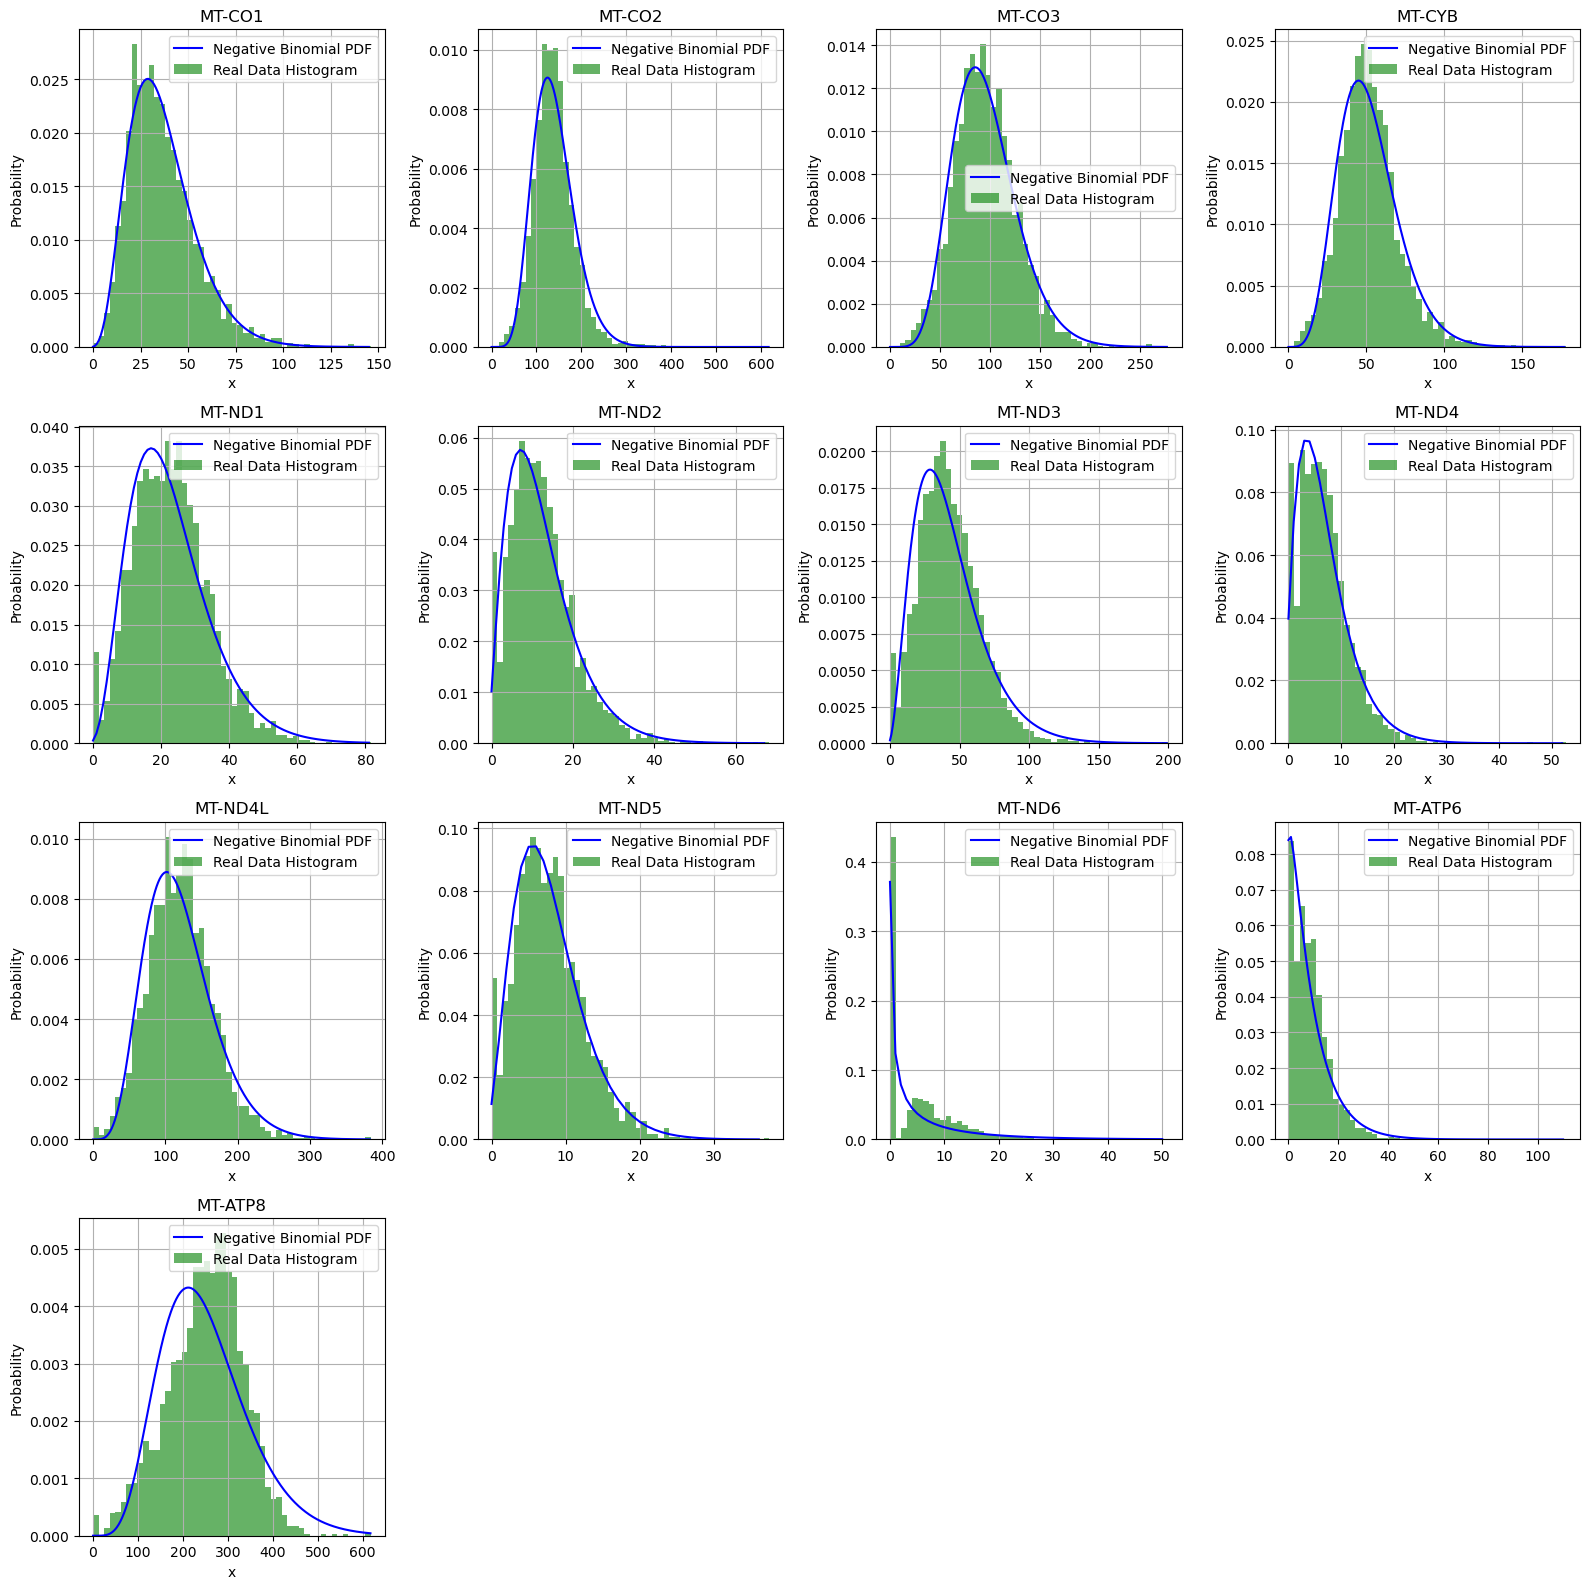

In [49]:


# Set up the plotting environment
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, key in enumerate(data_norm.columns):
    x = np.array(range(0, round(data_norm[key].max())))
    # Compute the Negative Binomial distribution PDF values
    pmf = [stats.nbinom.pmf(j, n=paras[i, 0], p=paras[i, 1]) for j in x]

    # Plot the Negative Binomial distribution
    axes[i].plot(x, pmf, color='b', label='Negative Binomial PDF')
    axes[i].hist(data_norm[key],  bins=50, density=True,
                 alpha=0.6, color='g', label='Real Data Histogram')

    # Set titles and labels
    axes[i].set_title(f'{key}')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('Probability')
    axes[i].legend()
    axes[i].grid(True)

# Delete the extra graphs
for j in range(13, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
